# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [1]:
#importing packages
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [2]:
trainTransaction=pd.read_csv('ieee-fraud-detection/train_transaction.csv')
trainIdentity=pd.read_csv('ieee-fraud-detection/train_identity.csv')

In [3]:
testTransaction=pd.read_csv('ieee-fraud-detection/test_transaction.csv')
testIdentity=pd.read_csv('ieee-fraud-detection/test_identity.csv')

In [4]:
print(trainTransaction.shape)
print(trainIdentity.shape)
print(testTransaction.shape)
print(testIdentity.shape)

(590540, 394)
(144233, 41)
(506691, 393)
(141907, 41)


In [5]:
trainMerged = pd.merge(trainTransaction, trainIdentity, on='TransactionID', how='left')
testMerged = pd.merge(testTransaction, testIdentity, on='TransactionID', how='left')
trainInnerMerged = pd.merge(trainTransaction, trainIdentity, on='TransactionID', how='inner')
testInnerMerged = pd.merge(testTransaction, testIdentity, on='TransactionID', how='inner')

In [6]:
print(trainMerged.shape)
print(testMerged.shape)

(590540, 434)
(506691, 433)


In [7]:
print("Number of transactions (merged): {}".format(trainMerged['TransactionAmt'].shape[0]))
print("Mean value of all: {0:.2f}".format(trainMerged['TransactionAmt'].mean()))
print("Max value: {0:.2f}".format(trainMerged['TransactionAmt'].max()))
print("Min value: {0:.2f}".format(trainMerged['TransactionAmt'].min()))

Number of transactions (merged): 590540
Mean value of all: 135.03
Max value: 31937.39
Min value: 0.25


In [8]:
#fraudulent vs. non- fraudulent-transactions 

fraudTransaction = trainMerged[trainMerged['isFraud']==1]
nonFraudTransaction = trainMerged[trainMerged['isFraud']==0]

print("Total Number of transactions: {}".format(trainMerged.shape[0]))
print("Total Number of Fraud transactions: {}".format(fraudTransaction.shape[0]))
print("Percentage of fraudulent transactions: {}".format(100*(fraudTransaction.shape[0]/trainMerged.shape[0])))
print("Percentage of Non-fraudulent transactions: {}".format(100*(nonFraudTransaction.shape[0])/trainMerged.shape[0]))

Total Number of transactions: 590540
Total Number of Fraud transactions: 20663
Percentage of fraudulent transactions: 3.4990009144173126
Percentage of Non-fraudulent transactions: 96.50099908558269


In [9]:
columnsNeeded =['TransactionID','isFraud', 'DeviceType','DeviceInfo','TransactionDT','TransactionAmt','ProductCD','card4'
               ,'card6','P_emaildomain','R_emaildomain','addr1','addr2','dist1','dist2']
fraudTransaction=fraudTransaction[columnsNeeded]
nonFraudTransaction = nonFraudTransaction[columnsNeeded]

In [10]:
fraudTransaction['TransactionDT']=(fraudTransaction['TransactionDT']-fraudTransaction['TransactionDT'].min())%86400
nonFraudTransaction['TransactionDT']=(nonFraudTransaction['TransactionDT']-nonFraudTransaction['TransactionDT'].min())%86400

In [11]:
fraudTransaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2
count,2.066300e+04,20663.0,20663.000000,20663.000000,12922.000000,12922.000000,4755.000000,3731.000000
mean,3.294952e+06,1.0,51100.789672,149.244779,294.317134,86.286024,174.588854,201.472259
std,1.620403e+05,0.0,26712.801532,232.212163,103.584955,4.936238,424.232313,451.589576
min,2.987203e+06,1.0,0.000000,0.292000,110.000000,10.000000,0.000000,0.000000
25%,3.167366e+06,1.0,24901.500000,35.044000,204.000000,87.000000,3.000000,7.000000
50%,3.291934e+06,1.0,59796.000000,75.000000,299.000000,87.000000,10.000000,49.000000
75%,3.428646e+06,1.0,72707.000000,161.000000,330.000000,87.000000,85.500000,233.000000
max,3.577526e+06,1.0,86399.000000,5191.000000,536.000000,96.000000,4942.000000,9337.000000


In [12]:
nonFraudTransaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2
count,5.698770e+05,569877.0,569877.000000,569877.000000,511912.000000,511912.000000,233514.000000,33896.000000
mean,3.281810e+06,0.0,51777.190129,134.511665,290.643341,86.813620,117.360098,235.199758
std,1.707548e+05,0.0,27405.426572,239.395078,101.692564,2.607742,370.641879,536.798492
min,2.987000e+06,0.0,0.000000,0.251000,100.000000,13.000000,0.000000,0.000000
25%,3.133317e+06,0.0,24971.000000,43.970000,204.000000,87.000000,3.000000,7.000000
50%,3.281808e+06,0.0,60646.000000,68.500000,299.000000,87.000000,8.000000,36.000000
75%,3.429974e+06,0.0,73478.000000,120.000000,330.000000,87.000000,24.000000,206.000000
max,3.577539e+06,0.0,86399.000000,31937.391000,540.000000,102.000000,10286.000000,11623.000000


## The Data is Right-skewed as most of the transactions are of small amounts

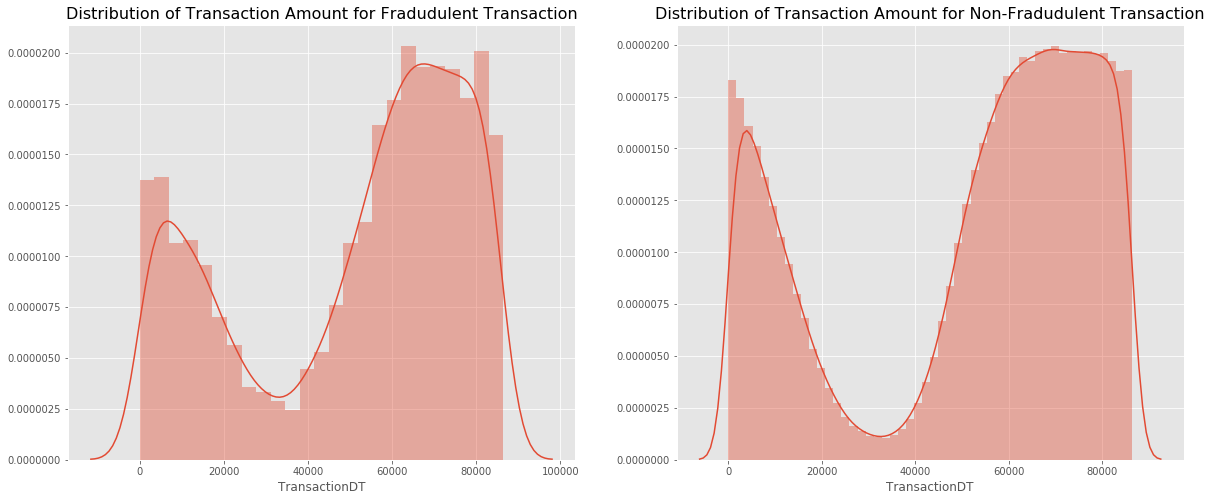

In [13]:
fig, axes = plt.subplots(1,2, figsize=(20, 8))
sns.distplot(fraudTransaction['TransactionDT'], ax = axes[0]).set_title('Distribution of Transaction Amount for Fradudulent Transaction', fontsize=16)
sns.distplot(nonFraudTransaction['TransactionDT'], ax = axes[1]).set_title('Distribution of Transaction Amount for Non-Fradudulent Transaction', fontsize=16)
plt.show()

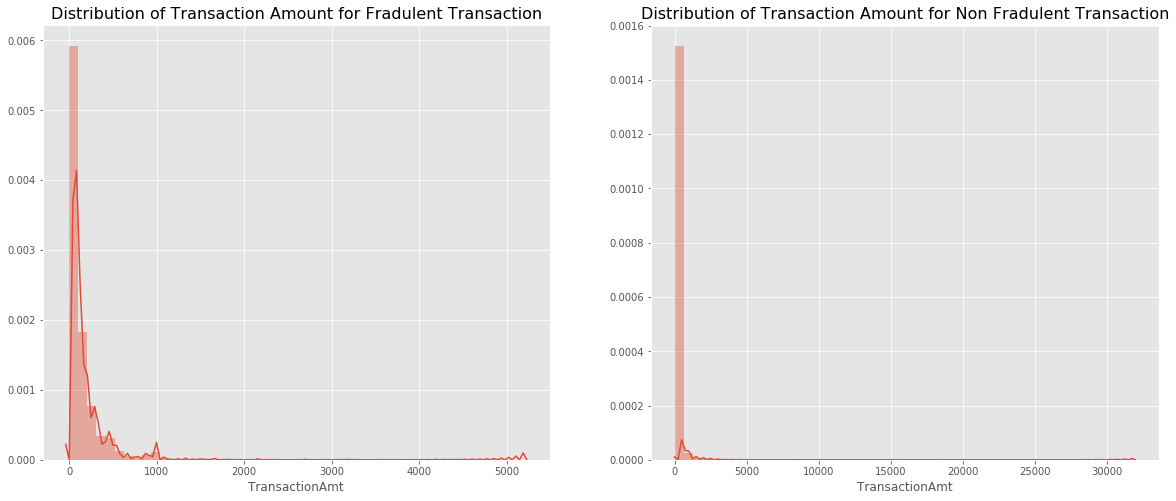

In [14]:
fig, axes = plt.subplots(1,2, figsize=(20, 8))
sns.distplot(fraudTransaction['TransactionAmt'], ax = axes[0]).set_title('Distribution of Transaction Amount for Fradulent Transaction', fontsize=16)
sns.distplot(nonFraudTransaction['TransactionAmt'], ax = axes[1]).set_title('Distribution of Transaction Amount for Non Fradulent Transaction', fontsize=16)
plt.show()

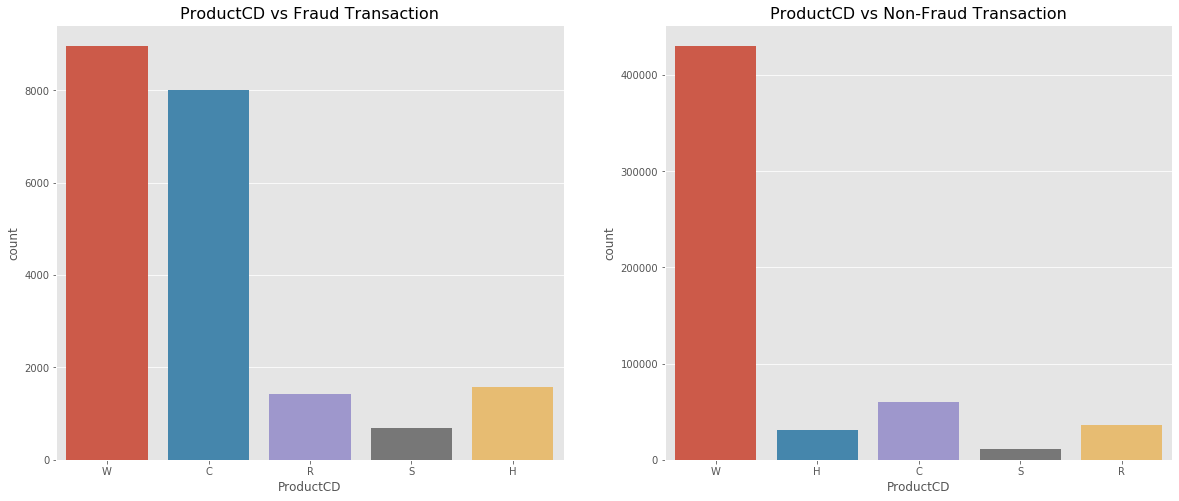

In [15]:
fig, axes = plt.subplots(1,2, figsize=(20, 8))
sns.countplot(fraudTransaction['ProductCD'], ax = axes[0]).set_title('ProductCD vs Fraud Transaction', fontsize=16)
sns.countplot(nonFraudTransaction['ProductCD'], ax = axes[1]).set_title('ProductCD vs Non-Fraud Transaction', fontsize=16)
plt.show()

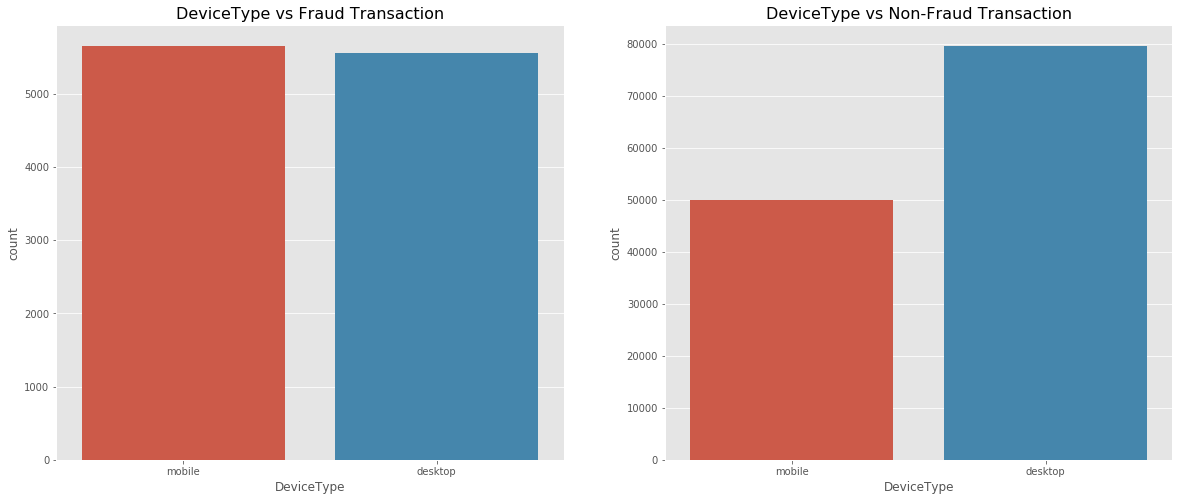

In [16]:
fig, axes = plt.subplots(1,2, figsize=(20, 8))
sns.countplot(trainInnerMerged[trainInnerMerged['isFraud']==1]['DeviceType'], ax = axes[0]).set_title('DeviceType vs Fraud Transaction', fontsize=16)
sns.countplot(trainInnerMerged[trainInnerMerged['isFraud']==0]['DeviceType'], ax = axes[1]).set_title('DeviceType vs Non-Fraud Transaction', fontsize=16)
plt.show()

### Findings for Q1:

1) Most of the transactionAmount data is right-skewed meaning most of the TransactionAmounts are small. <br>
We don't see a great amount of difference between the Fradulent and Non-Fradulent transactions w.r.t. Transaction Amount for small values.<br>

2) The hour of transaction is almost same for both Fradulent and non-Fradulent Transaction

Mean for fraudTransaction = 149 <br>
Mean for nonFraudTransaction = 134 <br>

3) __The produtCD -"C" has very high values of fraudTransactions__ <br>

4) __Percentage of fraudulent transactions on mobile as compared to overall transactions on mobile, <br>
for desktop they seem to be almost same.
We can guess maybe more fraudulent transactions occur on mobile.__

## Part 2 - Transaction Frequency

#### addr2 is in train_transaction and TransactionDT is in train_transaction.
#### So, we will only use this dataframe for this question, by removing null values(if present)

In [17]:
# Preparing the DataSet

columnsNeeded =['addr2','TransactionDT']
trainTransactionQ2 = trainTransaction[columnsNeeded]

In [18]:
#Checking for null values
trainTransactionQ2.isna().any()

addr2             True
TransactionDT    False
dtype: bool

In [19]:
# We will calculate how many null values are there in these columns (just to see how many are null im that column)
count_nan = len(trainTransactionQ2) - trainTransactionQ2.count()
count_nan

addr2            65706
TransactionDT        0
dtype: int64

## There are few rows in addr2 which does not have any value, we will drop such rows

In [20]:
print('Shape before removing nullrows {} '.format(trainTransactionQ2.shape))
rowsBefore=trainTransactionQ2.shape[0] 
trainTransactionQ2 = trainTransactionQ2.dropna()
rowsAfter=trainTransactionQ2.shape[0] 
print('Shape after removing nullrows {} '.format(trainTransactionQ2.shape))
print('Difference in size = {} '.format(rowsBefore - rowsAfter))

Shape before removing nullrows (590540, 2) 
Shape after removing nullrows (524834, 2) 
Difference in size = 65706 


#### Country with max transactions (Highest Frequncy count in addr2)

In [22]:
maxTransactionsCountry = trainTransactionQ2['addr2'].value_counts().nlargest(1)
countryCode = int(maxTransactionsCountry.index.values)
Value = int(maxTransactionsCountry.values)
print("The country code for most number of transactions is {} and number of occurences is {}".
      format(countryCode, Value))

The country code for most number of transactions is 87 and number of occurences is 520481


In [23]:
trainTransactionQ2['TransactionDTInSeconds']=(trainTransactionQ2['TransactionDT']-trainTransactionQ2['TransactionDT'].min())%86400
trainTransactionQ2['TransactionDTInHours']=(trainTransactionQ2['TransactionDTInSeconds']/(3600)).apply(np.floor)
trainTransactionQ2['TransactionDTInDays']=(trainTransactionQ2['TransactionDT']/(3600*24)).apply(np.floor)-1
trainTransactionQ2['TransactionDTInWeeks']=(trainTransactionQ2['TransactionDTInDays'])%7
trainTransactionQ2['TransactionDTInMonths']=(trainTransactionQ2['TransactionDTInDays'])%30

#### We can validate the values in the below dataframae, using min and max values:
For time in seconds min=0, max =86399 <br>
For time in Hours min=0, max =23 (24 hours a day) <br>
For time in Days min=0, max =6 (7 days a week) <br>
Total days = 181 (~6 months of data) <br>

In [24]:
trainTransactionQ2[['TransactionDTInSeconds','TransactionDTInHours','TransactionDTInDays',
                    'TransactionDTInWeeks','TransactionDTInMonths']].describe()

,TransactionDTInSeconds,TransactionDTInHours,TransactionDTInDays,TransactionDTInWeeks,TransactionDTInMonths
count,524834.000000,524834.000000,524834.000000,524834.000000,524834.000000
mean,52378.215933,14.047693,83.648304,2.987747,13.936205
std,27073.795832,7.508975,53.693305,2.045843,8.750065
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35371.500000,9.000000,33.000000,1.000000,6.000000
50%,60919.000000,16.000000,83.000000,3.000000,14.000000
75%,73577.000000,20.000000,129.000000,5.000000,21.000000
max,86399.000000,23.000000,181.000000,6.000000,29.000000


#### We can see that there is quiet period during the early hours of the day and more transactions during evening as one would expect.

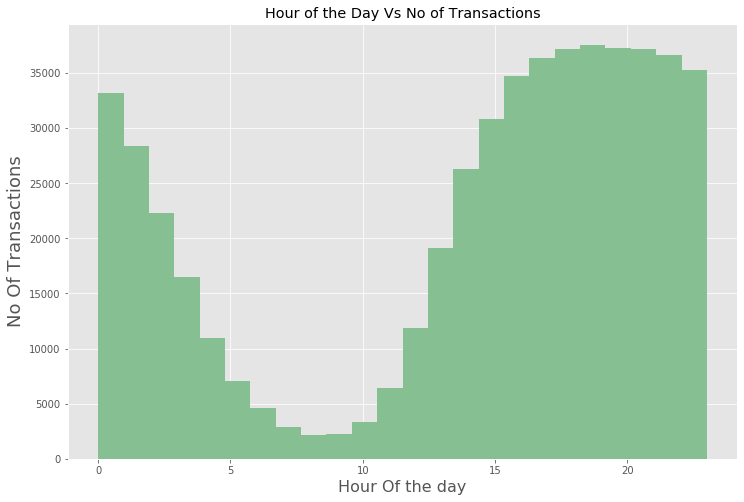

In [25]:
trainTransactionQ2[trainTransactionQ2['addr2']==87].hist(column='TransactionDTInHours',bins=24,
                                                         figsize=(12,8), color='#86bf91')
plt.title('Hour of the Day Vs No of Transactions')
plt.ylabel('No Of Transactions', fontsize=18)
plt.xlabel('Hour Of the day', fontsize=16)
plt.show()

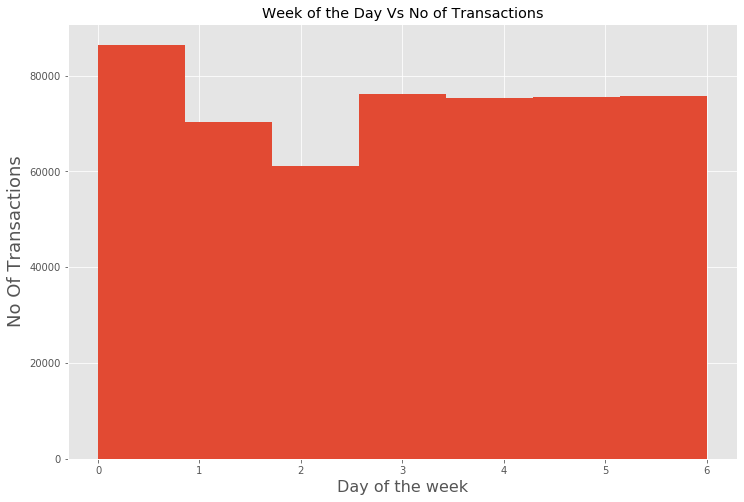

In [26]:
trainTransactionQ2[trainTransactionQ2['addr2']==87].hist(column='TransactionDTInWeeks',bins=7,  
                                                         figsize=(12,8))
plt.title('Week of the Day Vs No of Transactions')
plt.ylabel('No Of Transactions', fontsize=18)
plt.xlabel('Day of the week', fontsize=16)
plt.show()

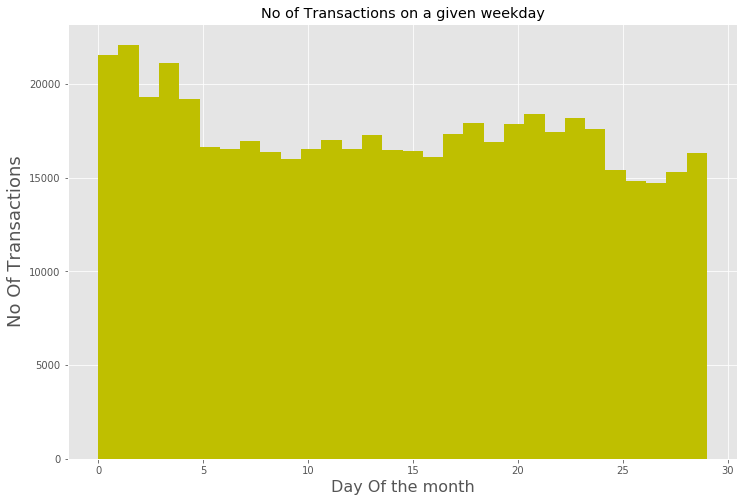

In [27]:
trainTransactionQ2[trainTransactionQ2['addr2']==87].hist(column='TransactionDTInMonths',bins=30,  figsize=(12,8), color='y')
plt.title('No of Transactions on a given weekday')
plt.ylabel('No Of Transactions', fontsize=18)
plt.xlabel('Day Of the month', fontsize=16)
plt.show()

#### Delete temp dataframe after use

In [28]:
del trainTransactionQ2

## Findings for Q2:

1) There is a clear pattern in number of transactions that occurred during different hours of the day and as one would expect the transactions were few in the early hours of the day and peaked during the evening as one would expect.

2) I expected the spending would be more on weekends and same throughout the weekdays buut the data shows only 1 spike (probably on a saturday/sunday), but we are not sure about the spending patterns on weekends

3) One intresting find was to see how we spend throught thee month, as expected we can see there are more number of transactions during the begining of the month and less during the end

## Part 3 - Product Code

#### ProductCD is in train_transaction and TransactionAmt is in train_transaction.
#### So, we will only use this dataframe for this question, by removing null values(if present)

In [29]:
# Preparing the DataSet

columnsNeeded =['ProductCD','TransactionAmt']
trainTransactionQ3 = trainTransaction[columnsNeeded]

#### No Null values here

In [30]:
#Checking for null values
trainTransactionQ3.isna().any()

ProductCD         False
TransactionAmt    False
dtype: bool

### Preparing a new column percentile to rank the items based on TransactionAmt

In [31]:
trainTransactionQ3['Percentile']= trainTransactionQ3.TransactionAmt.rank(pct=True)

/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Let's see which products are bought within the top 10 percentile

In [32]:
data = pd.DataFrame([])
for percentile in range(1,11):
    tempDf=trainTransactionQ3[trainTransactionQ3['Percentile']>1-0.01*percentile].ProductCD.value_counts().nlargest(1)
    mean  = trainTransactionQ3[trainTransactionQ3['Percentile']>1-0.01*percentile].TransactionAmt.mean()
    size = trainTransactionQ3[trainTransactionQ3['Percentile']>(1-0.01*percentile)].shape[0]
    data = data.append(pd.DataFrame(
        {'Percentile Score':str(100-percentile)+'%',
         'ProductCD with max values':tempDf.index, 
         'Count within that percentile':tempDf.values,
         'Mean TransactionAmt':mean,
         'Perrcentage of max ProductCD':(tempDf.values)*100/size}), 
                       ignore_index=True)


print("==============================================") 
print("Frequently Bought Product within top 10 percentile") 
print("For the costliest items") 
data

Frequently Bought Product within top 10 percentile
For the costliest items


,Percentile Score,ProductCD with max values,Count within that percentile,Mean TransactionAmt,Perrcentage of max ProductCD
0,99%,W,5588,1908.514533,99.060450
1,98%,W,11296,1400.315510,95.615372
2,97%,W,16329,1164.623286,94.518407
3,96%,W,22520,981.106999,92.583457
4,95%,W,27471,888.495509,92.933018
5,94%,W,32715,809.261129,92.329185
6,93%,W,35974,768.984401,92.385526
7,92%,W,44236,691.776935,93.589472
8,91%,W,48965,656.891739,94.112785
9,90%,W,53861,613.122950,91.207898


## Let's define what expensive is

We will define all those transactions which are 3 std away from mean or >99.7 are expensive

In [33]:
data = pd.DataFrame([])
for percentile in range(0,6):
    tempDf=trainTransactionQ3[trainTransactionQ3['Percentile']>0.997+0.0005*percentile].ProductCD.value_counts().nlargest(1)
    mean  = trainTransactionQ3[trainTransactionQ3['Percentile']>0.997+0.0005*percentile].TransactionAmt.mean()
    size = trainTransactionQ3[trainTransactionQ3['Percentile']>(0.997 + 0.0005*percentile)].shape[0]
    data = data.append(pd.DataFrame(
        {'Percentile Score':str(99.7+0.05*percentile)+'%',
         'ProductCD with max values':tempDf.index, 
         'Count within that percentile':tempDf.values,
         'Mean TransactionAmt':mean,
         'Perrcentage of max ProductCD':(tempDf.values)*100/size}), 
                       ignore_index=True)


print("Frequently Bought Product within that percentile") 
print("For the costliest items") 
data

Frequently Bought Product within that percentile
For the costliest items


,Percentile Score,ProductCD with max values,Count within that percentile,Mean TransactionAmt,Perrcentage of max ProductCD
0,99.7%,W,1814,2712.626280,100.0
1,99.75%,W,1476,2847.953125,100.0
2,99.8%,W,1181,2994.692787,100.0
3,99.85000000000001%,W,888,3170.735092,100.0
4,99.9%,W,591,3435.093066,100.0
5,99.95%,W,296,3924.927878,100.0


#### There is a clear winner here, ProductCD with 'W' has the most expensive transactionsm

### Cheapest Product analysis

Simnilar to the costliest , let's define cheapest as those products which are 3 std away from mean, now in the opposite direction (transaction amounts < 99.7% as compared to others )


In [34]:
data = pd.DataFrame([])
for percentile in range(1,7):
    tempDf=trainTransactionQ3[trainTransactionQ3['Percentile']<0.00005*percentile].ProductCD.value_counts().nlargest(1)
    mean  = trainTransactionQ3[trainTransactionQ3['Percentile']<0.00005*percentile].TransactionAmt.mean()
    size = trainTransactionQ3[trainTransactionQ3['Percentile']<(0.00005*percentile)].shape[0]
    data = data.append(pd.DataFrame(
        {'Percentile Score':str(0.005*percentile)+'%',
         'ProductCD with max values':tempDf.index, 
         'Count within that percentile':tempDf.values,
         'Mean TransactionAmt':mean,
         'Perrcentage of max ProductCD':sum(tempDf.values)*100/size}), 
                       ignore_index=True)


print("==============================================") 
print("Frequently Bought Product in the last 10 percentile") 
print("For the cheapest items items") 
data

Frequently Bought Product in the last 10 percentile
For the cheapest items items


,Percentile Score,ProductCD with max values,Count within that percentile,Mean TransactionAmt,Perrcentage of max ProductCD
0,0.005%,C,29,0.438069,100.000000
1,0.01%,C,41,0.515220,100.000000
2,0.015%,C,41,0.515220,100.000000
3,0.02%,C,142,0.773254,100.000000
4,0.025%,C,147,0.778551,100.000000
5,0.03%,C,168,0.816933,93.854749


#### Delete temp dataframe after use

In [35]:
del trainTransactionQ3

## Findings for Q3:

1) Most expensive ProuctCD: 'W'<br>
2) Cheapest ProuctCD: 'C'


## Guess for product

1) Most expensive is around ~2700 -> Electronics(Gaming Laptop's, UHD TV's) or Home appliances(like Furniture- Sleeper Sofas) <br>
2) LeastExpensive is arounf ~0.80 -> <br> (i) Items from dollar tree (as items in the cheapest range are <1) <br>
                                         (ii) Buying a single fruit/vegetable from a small vendor

## Part 4 - Correlation Coefficient

#### TransactionDT is in train_transaction and TransactionAmt is in train_transaction.
#### So, we will only use this dataframe for this question, by removing null values(if present)

In [36]:
# Preparing the DataSet

columnsNeeded =['TransactionDT','TransactionAmt']
trainTransactionQ4 = trainTransaction[columnsNeeded]

### No Null Values

In [37]:
#Checking for null values
trainTransactionQ4.isna().any()

TransactionDT     False
TransactionAmt    False
dtype: bool

#### Preparing columns with information regarding time (in  Hours)

In [38]:
trainTransactionQ4['TransactionDTInSeconds']=(trainTransactionQ4['TransactionDT']-trainTransactionQ4['TransactionDT'].min())%86400
trainTransactionQ4['TransactionDTInHours']=(trainTransactionQ4['TransactionDTInSeconds']/(3600)).apply(np.floor)

/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


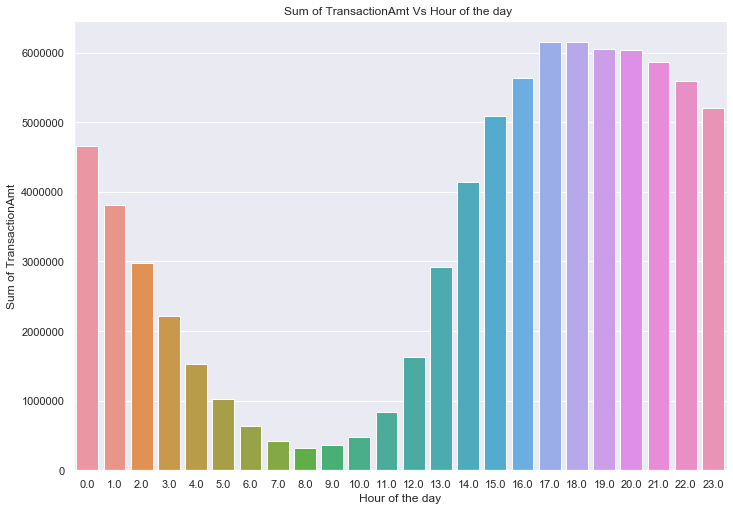

In [39]:
head=trainTransactionQ4.groupby(['TransactionDTInHours'])['TransactionAmt'].sum()
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(head.index,head.values)
#If you want to display the value at the top
#for i, v in enumerate(head.iteritems()):        
#    plot.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plot.set(xlabel='Hour of the day', ylabel='Sum of TransactionAmt')
plt.title("Sum of TransactionAmt Vs Hour of the day ")
plt.show()

### Correlation of Sum(TransactionAmt) Vs Hour Of the day 

In [40]:
#Correlation
x=pd.DataFrame({'hourofTheDay':head.index, 'TransactionAmtSum':head.values})
corr = x.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,hourofTheDay,TransactionAmtSum
hourofTheDay,1,0.64
TransactionAmtSum,0.64,1


### Correlation of TransactionAmt Vs Hour Of the day 

In [41]:
#Correlation
xNeeded=['TransactionDTInSeconds','TransactionAmt']
head=trainTransactionQ4[xNeeded]
corr = head.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,TransactionDTInSeconds,TransactionAmt
TransactionDTInSeconds,1,0.045
TransactionAmt,0.045,1


## Deleting this dataframe

In [42]:
del trainTransactionQ4

## Findings for Q4:

Simiiar to Q2 where we plotted Hour of the day vs Number of transactions, we see a similar trend for this one as well, where there is a lean period during the early hours of the day and transactions spiked up during the evening so as the sum of TrsancationAmount <br>

The correlation between __time of the hour__ and the __sum of transaction amount__ is 0.65. <br>
This seems to be reasonable as initially the sum is low and later it peaked and towards the end(late night) it reduced again so the correlation value we got is in th range. <br>

The correlation between __time of the hour__ and the __transaction amount__ is 0.04.

## Part 5 - Interesting Plot

### The Correlation between TransactionDT and D9

In [43]:
# Preparing the DataSet

columnsNeeded =['TransactionDT','TransactionAmt']
trainTransactionQ5 = trainTransaction[columnsNeeded]
trainTransactionQ5['TransactionDTInSeconds']=(trainTransactionQ5['TransactionDT']-trainTransactionQ5['TransactionDT'].min())%86400


/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [44]:
timeScaler = StandardScaler()
scaled_time = timeScaler.fit_transform(trainTransactionQ5[['TransactionDTInSeconds']])
flat_list_time = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(flat_list_time)

df = pd.DataFrame()
b=trainTransaction[['D9']]
df = pd.concat([df,  scaled_time.rename('scaled TransactionDT'),b], axis=1)

In [45]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,scaled TransactionDT,D9
scaled TransactionDT,1,0.999
D9,0.999,1


### Findings for Q5:

1) There is a very intresting correlation (>0.99) between the scaled value of TransactionTime from train_tansaction <br> and the columnn "D9" from train_tansaction. <br>

This is intresting as the __meaning of the columns D1-D15 were masked but it turned out one of them was nothing but a scaled value of time__ (after taking modulo operation) columns


2) They were few transanctions which had TransactionAmt upto __3 decimal places__ probably these could be some __International transactions__ as some forex charge may have been applied 

## Part 6 - Prediction Model

### Building a model

In [46]:
print("Total Number of transactions: {}".format(trainTransaction.shape[0]))
print("Total Number of Fraud transactions: {}".format(fraudTransaction.shape[0]))
print("Percentage of fraudulent transactions: {}".format(100*(fraudTransaction.shape[0]/trainTransaction.shape[0])))
print("Percentage of Non-fraudulent transactions: {}".format(100*(nonFraudTransaction.shape[0])/trainTransaction.shape[0]))

Total Number of transactions: 590540
Total Number of Fraud transactions: 20663
Percentage of fraudulent transactions: 3.4990009144173126
Percentage of Non-fraudulent transactions: 96.50099908558269


### As There are only 3.5% fraud Transactions, even if I simply create a model labeling all transactions are Non-Fraudulent, I'll still get an accuracy of 96.5%
### But this model isn't helpful in actual prediction

In [47]:
def preProcessData(df):
    
    #Int null values replace with median
    df=df.fillna(df.median())
    #Str null values replace with '-'
    df=df.fillna('-')
    
    labenc = LabelEncoder()
    #Encoder will convert everything into int
    df=df.apply(labenc.fit_transform)
    
    # Scale Time and Amount
    timeScaler = StandardScaler()
    amountSscaler = StandardScaler()

    df['TransactionDT2'] = (df['TransactionDT']-df['TransactionDT'].min())%86400

    #scaling time
    scaled_time = timeScaler.fit_transform(df[['TransactionDT2']])
    flat_list_time = [item for sublist in scaled_time.tolist() for item in sublist]
    scaled_time = pd.Series(flat_list_time)

    #scaling the amount column
    scaled_amount = amountSscaler.fit_transform(df[['TransactionAmt']])
    flat_list_amount = [item for sublist in scaled_amount.tolist() for item in sublist]
    scaled_amount = pd.Series(flat_list_amount)

    #concatenating newly created columns
    df = pd.concat([df, scaled_amount.rename('scaledTransactionAmt'), scaled_time.rename('scaledTransactionDT')], axis=1)

    #dropping
    df.drop(['TransactionAmt', 'TransactionDT','TransactionDT2','TransactionID'], axis=1, inplace=True)

    
    return df

In [51]:
processedDF = trainMerged
processedDF = preProcessData(processedDF)

In [52]:
processedDF.drop(['isFraud'], axis=1, inplace=True)

In [53]:
processedDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 432 entries, ProductCD to scaledTransactionDT
dtypes: float64(2), int64(430)
memory usage: 1.9 GB


In [54]:
Y = trainMerged['isFraud']

In [55]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processedDF, Y, test_size=0.3, random_state=42)

In [56]:
lm = LinearRegression()
lmPred = lm.fit(X_train,y_train)
predictions = lmPred.predict(X_test)
mean_squared_error(y_test, predictions)

0.026710422165269337

In [57]:
processedDFTest=testMerged
processedDFTest = preProcessData(processedDFTest)
predictionTest = lmPred.predict(processedDFTest)

In [58]:
output = pd.DataFrame()
output["TransactionID"] = testMerged["TransactionID"]
output["isFraud"] = predictionTest
output.to_csv("bharath.csv",index=False)

### Findings for Q6:

1) We started with a simple model, where we were guessing as a non-fraudulent transaction for every transaction,<br>
but this is not a good model, as it doesn't help us with predicting future values. <br>

2) Then, data pre-processing was performed by removing NA values folowed by scaling time and TransactionAmt.<br>

3) Then, we split the data for test and train. <br>

4) We fit the model on a Linerar Refression with a mean_squared_error of 0.026


## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/bharathmvsn

Highest Rank: 5061

Score: 0.8666

Number of entries: 2

INCLUDE IMAGE OF YOUR KAGGLE RANKING

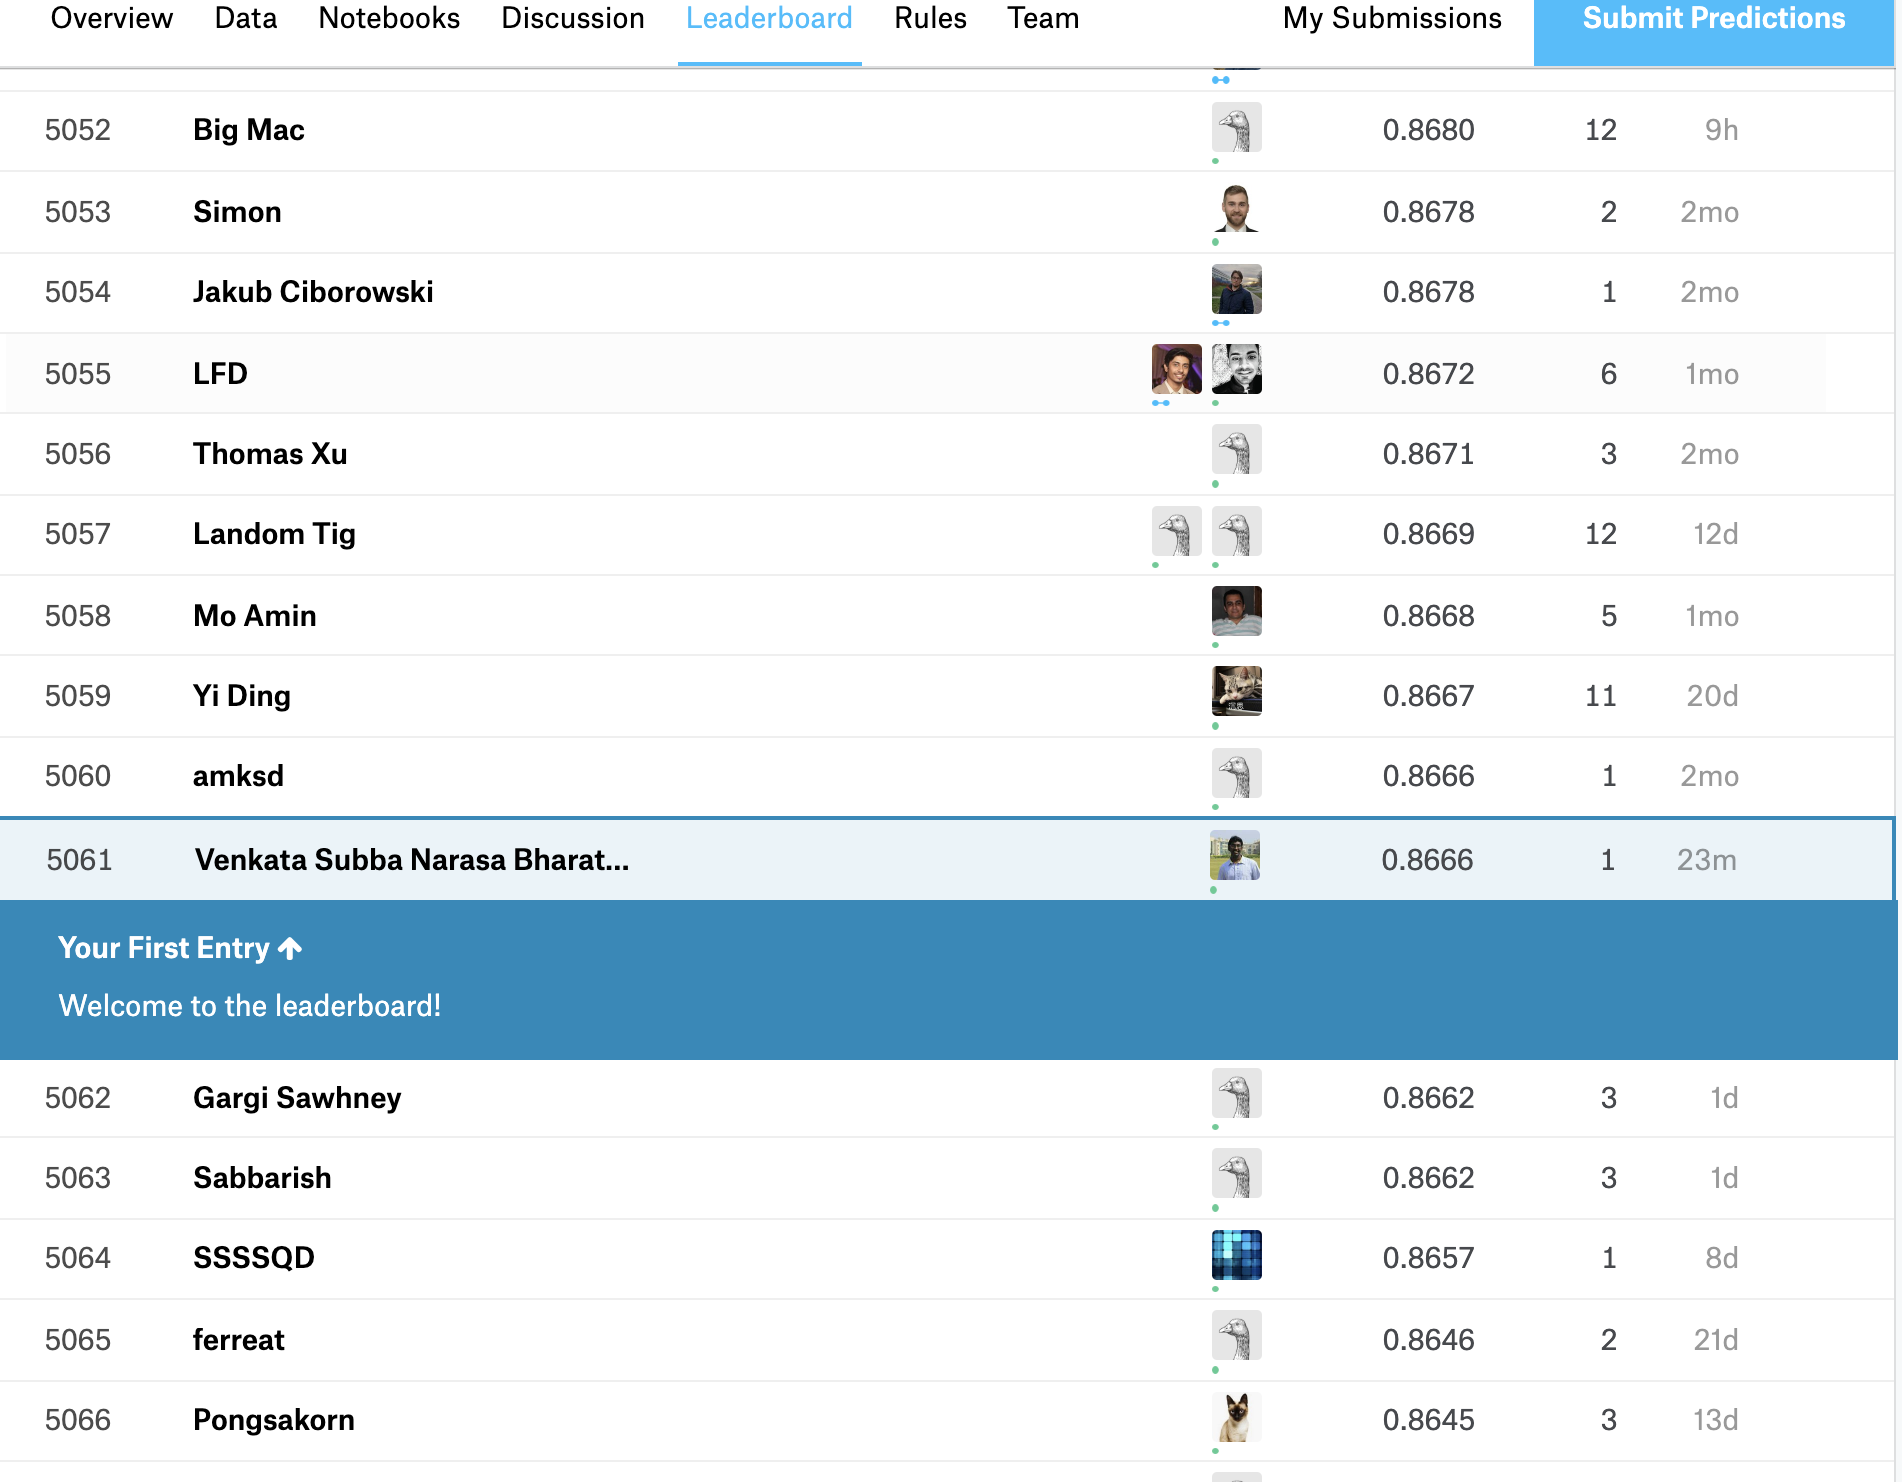